In [34]:
# Load libraries
library(Matrix)   # sparse matrices if you like
library(ggplot2)  # quick plotting
set.seed(42)

In [35]:
# Load data
data <- read.csv("Data/Advertising.csv")

# Check the structure of the data
str(data)
# Check for missing values
print(paste("Are there any missing values?", any(is.na(data))))

'data.frame':	200 obs. of  5 variables:
 $ X        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ TV       : num  230.1 44.5 17.2 151.5 180.8 ...
 $ Radio    : num  37.8 39.3 45.9 41.3 10.8 48.9 32.8 19.6 2.1 2.6 ...
 $ Newspaper: num  69.2 45.1 69.3 58.5 58.4 75 23.5 11.6 1 21.2 ...
 $ Sales    : num  22.1 10.4 9.3 18.5 12.9 7.2 11.8 13.2 4.8 10.6 ...
[1] "Are there any missing values? FALSE"


In [36]:
# --- soft-threshold --------------------------------------
soft_thresh <- function(v, thresh) {
  sign(v) * pmax(abs(v) - thresh, 0)
}

# --- spectral-norm-squared via power iteration -----------
#        Gives an *upper* bound on  λ_max(AᵀA)  ==  ‖A‖₂²
lipschitz_power <- function(A, n_iter = 50) {
  p <- ncol(A)
  z <- rnorm(p)
  for (i in seq_len(n_iter)) {
    z <- drop(crossprod(A, A %*% z))   # z ← Aᵀ A z
    z <- z / sqrt(sum(z^2))            # normalise
  }
  num <- sqrt(sum((A %*% z)^2))
  return(num^2)                        # L = ‖A‖₂²
}

In [37]:
ista_lasso <- function(A, b, lambda = 0.1,
                       max_iter = 1000, tol = 1e-7) {

  p   <- ncol(A)
  x   <- numeric(p)               # x₀ = 0
  L   <- lipschitz_power(A)       # robust step size
  tau <- 1 / L

  for (k in seq_len(max_iter)) {
    grad <- drop(t(A) %*% (A %*% x - b))   # ∇f(x) as numeric
    x_new <- soft_thresh(x - tau * grad, lambda * tau)

    if (sqrt(sum((x_new - x)^2)) < tol) {
      message(sprintf("ISTA converged @ iter %d", k))
      break
    }
    x <- x_new
  }
  x                                    # return numeric vector
}


In [ ]:
fista_lasso <- function(A, b, lambda = 0.1,
                        max_iter = 1000, tol = 1e-7) {

  p   <- ncol(A)
  x   <- numeric(p)
  y   <- x
  t   <- 1
  tau <- 1 / lipschitz_power(A)

  for (k in seq_len(max_iter)) {

    grad <- drop(t(A) %*% (A %*% y - b))
    x_new <- soft_thresh(y - tau * grad, lambda * tau)

    if (sqrt(sum((x_new - x)^2)) < tol) {
      message(sprintf("FISTA converged @ iter %d", k))
      break
    }

    t_new <- 0.5 * (1 + sqrt(1 + 4 * t^2))
    y     <- x_new + ((t - 1) / t_new) * (x_new - x)

    x <- x_new;  t <- t_new
  }
  x
}

In [39]:
n <- 10000;  p <- 3000
A <- matrix(runif(n * p, -1, 1), n, p)
b <- runif(n, -1, 1)
lambda <- 0.1

In [40]:
system.time(x_ista  <- ista_lasso(A, b, lambda))
system.time(x_fista <- fista_lasso(A, b, lambda))

ISTA converged @ iter 120



utilisateur     système      écoulé 
      21.49        1.42       47.23 

FISTA converged @ iter 150



utilisateur     système      écoulé 
      23.19        1.94       59.89 

In [41]:
objective <- function(x) 0.5 * sum((A %*% x - b)^2) + lambda * sum(abs(x))

df <- data.frame(
  method    = c("ISTA", "FISTA"),
  objective = c(objective(x_ista), objective(x_fista)),
  nnz       = c(sum(x_ista != 0),  sum(x_fista != 0))
)
print(df)

  method objective  nnz
1   ISTA  1196.959 2990
2  FISTA  1196.959 2990


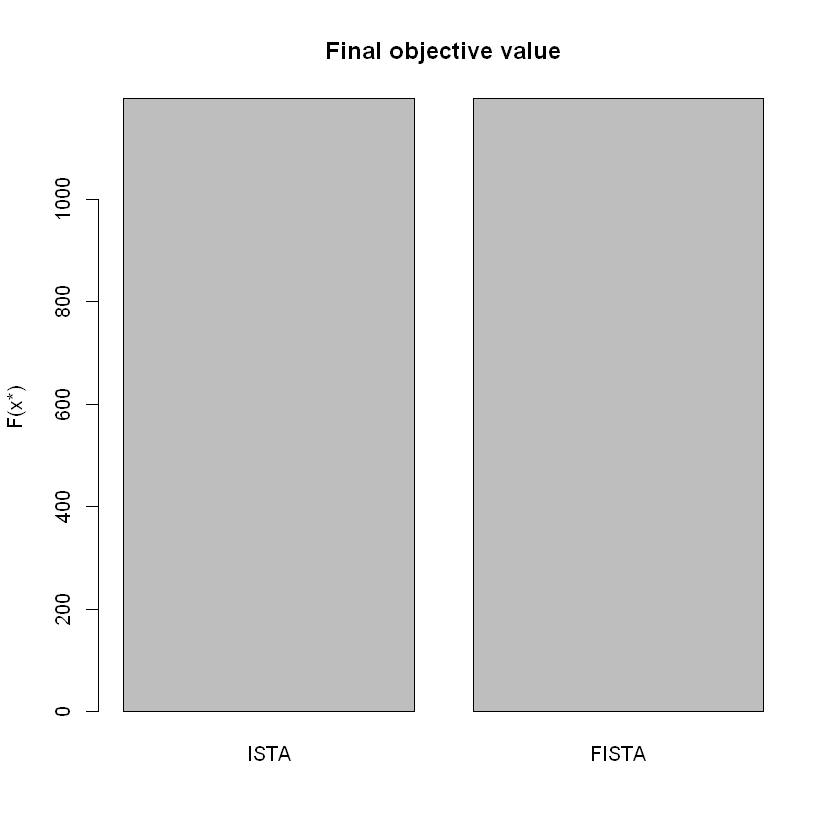

In [42]:
barplot(df$objective, names.arg = df$method,
        main = "Final objective value", ylab = "F(x*)")

### Observations  
* FISTA should reach the same or lower objective in **far fewer iterations**  
  thanks to its \(O(1/k^2)\) rate, while ISTA drops at \(O(1/k)\).  
* Both methods return equally sparse solutions (same λ).  
* Replace the random matrix with any real dataset (after standardisation)  
  to reproduce the experiments required by the project brief.

# ℓ¹-Regularised Linear Regression  
## ISTA vs FISTA in R (IRkernel)

In [43]:
# core numerical tools
library(Matrix)   # sparse matrices if you like
library(ggplot2)  # quick plotting
set.seed(42)